In [1]:
# Importing necessary libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from datetime import datetime
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate,GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score,mean_absolute_error,explained_variance_score
import time

In [2]:
# loading the data frame and converting attiributes to object type or datetime.
df = pd.read_csv('../data/listings_clean_dummy_encoding.csv')

# dropping host_id and host_since columns
df.drop(['host_id','host_since'],axis=1,inplace=True)

# performing dummy encoding
transformed_df = pd.get_dummies(df)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6882 entries, 0 to 6881
Data columns (total 46 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_time                            6882 non-null   object 
 1   host_response_rate                            6882 non-null   object 
 2   host_acceptance_rate                          6882 non-null   object 
 3   host_is_superhost                             6882 non-null   float64
 4   host_verifications                            6882 non-null   int64  
 5   host_has_profile_pic                          6882 non-null   float64
 6   host_identity_verified                        6882 non-null   float64
 7   neighbourhood                                 6882 non-null   object 
 8   property_type                                 6882 non-null   object 
 9   accommodates                                  6882 non-null   i

# Preprocessing:

The details of the imputation of missing values, pre-processing and encoding of several columns can be found in the data wrangling notebook. Object type columns will be encoded using dummy transformation.

# Model Selection:

Three models will be compared for the price prediction.

1. Linear Regression
2. Random Forest Regressor
3. XGBoost Regressor

Initially, these models will be compared w/o hyperparameter tuning and they will be compared for their prediction capabillit. Later on, the best model will be optimized with GridSearchCV.

Preprocessing of the Data:

Since XGBoost and Random Forest  are both tree based models, standardization or normalization of the data is not expected to make a difference on model performance. However, it would be impactful on linear regression. Thus, data will be normalized using MinMaxScaler.

In [4]:
# copying the data frame
df = transformed_df.copy()

# assigning X and y 
X = df.drop('price', axis=1)
y = df.price


# performing train_test_split    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalazing the data
norm = MinMaxScaler()
norm.fit(X_train)
norm.transform(X_train)
norm.transform(X_test)

# initiating the model
lm = LinearRegression()
xgb_reg = xgb.XGBRegressor()
rf_reg = RandomForestRegressor()
dummy = DummyRegressor()

models = [dummy, lm,xgb_reg,rf_reg]

for i in models:
    # fitting the model to dataset and making predictions on training and test data
    i.fit(X_train,y_train)
    y_train_pred = i.predict(X_train)
    y_test_pred = i.predict(X_test)
    
    # calculating r^2 for training and test data
    Train_r2 = round(r2_score(y_train, y_train_pred),4)
    Test_r2 = round(r2_score(y_test, y_test_pred),4)

    # printing r^2 for train and test data
    print('Results for model: ',i)
    print('R2 for training data is: ', Train_r2)
    print('R2 for test data is: ', Test_r2)

    # doing cross-validation
    cv = cross_validate(i, X_train, y_train, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

    # printing r^2 of the cross validation
    print('R2 for cross-validation of training data is: ',cv['train_r2'])    
    print('R2 for cross-validation of test data is: ',cv['test_r2'],'\n')

Results for model:  DummyRegressor()
R2 for training data is:  0.0
R2 for test data is:  -0.0004
R2 for cross-validation of training data is:  [0. 0. 0. 0. 0.]
R2 for cross-validation of test data is:  [-2.39179470e-03 -1.98788558e-03 -9.30323109e-06 -3.90541556e-03
 -1.14668482e-05] 

Results for model:  LinearRegression()
R2 for training data is:  0.1119
R2 for test data is:  0.0198
R2 for cross-validation of training data is:  [0.11096233 0.13586905 0.11398089 0.11759273 0.11237291]
R2 for cross-validation of test data is:  [ 0.09206259  0.06824833  0.08176806 -0.03721793  0.08609417] 

Results for model:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_

- All of the models showed poor performance. To get into details of it, lets focus on the results of the XGBoost Regressor model.
    - Let's plot actual vs predicted target variables.
    - Create a new variable called %error which gives %error done at predicting the target variable and plot %error vs actual target variable.

In [5]:
xgb_reg.fit(X_train,y_train)
y_train_pred = i.predict(X_train)
y_test_pred = i.predict(X_test)

In [6]:
# create a function to plot target vs prediction & target vs prediction error
def pred_plotter(data,prediction):
    
    x = data.values
    y = prediction
    error = 100 * (y-x)/x
    z = max(max(x),max(y))
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot([0,z],[0,z],ls="--",c = 'r')
    plt.scatter(x,y)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual price vs Predicted price')

    plt.subplot(1,2,2)
    plt.scatter(x,error)
    plt.xlabel('Actual Price')
    plt.ylabel('Error in Price Prediction')    
    plt.title('Actual price vs Prediction error')   

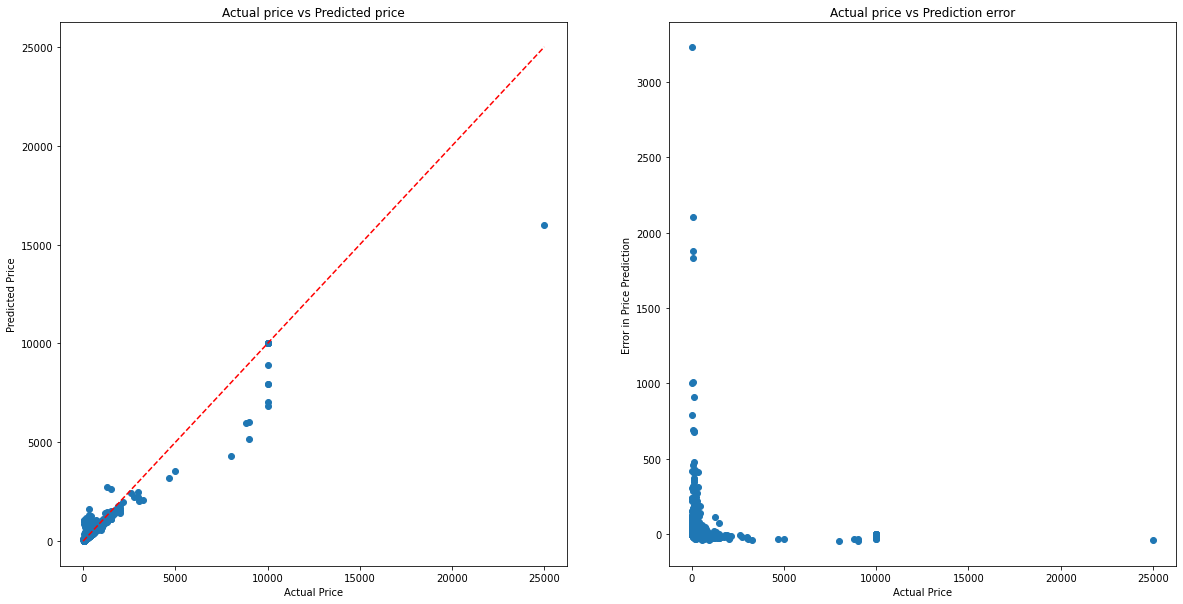

In [7]:
pred_plotter(y_train, y_train_pred)

- The prediction error is much higher at the lower prices than the higher prices. Let's check it for the test data as well.

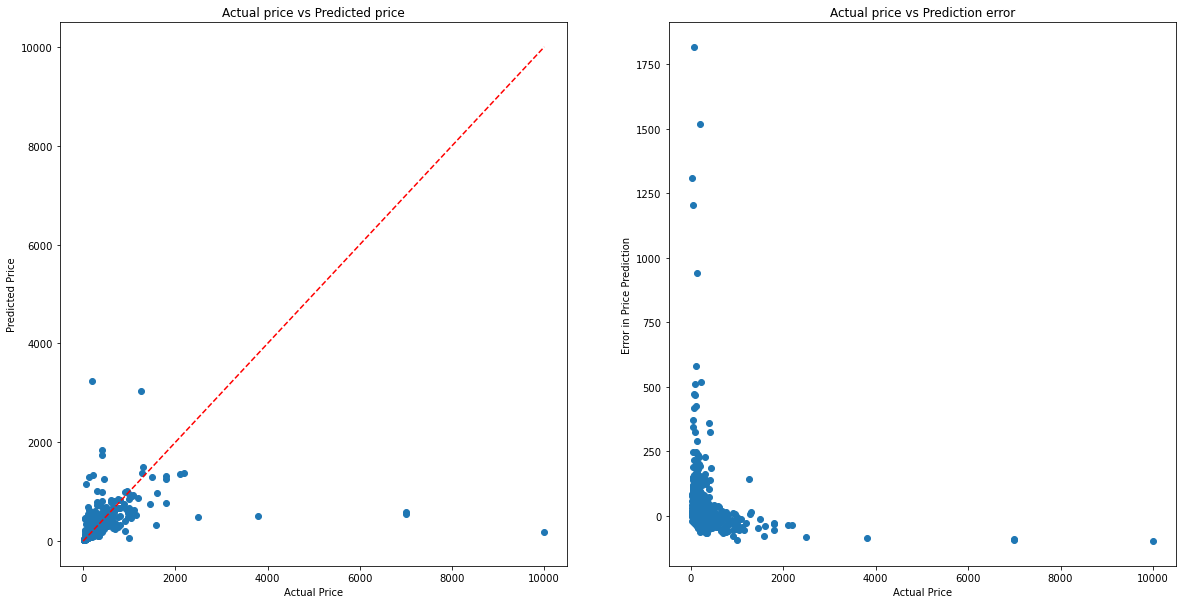

In [8]:
pred_plotter(y_test, y_test_pred)

- The predictions for both test and train data had very large errors at lower prices. 
    - Prices at low end could be entered wrong i.e. 5 bedrooms for 20 USD is a data entry error rather than real data considering the prices in SF Bay Area.
    - Outliers can impact the model performance.
- Lets look into price column and a new column 'price_per_accommodate' = price/accommodates

In [9]:
transformed_df['price_per_accommodate'] = transformed_df['price']/transformed_df['accommodates']
transformed_df['price_per_accommodate'].describe()

count     6882.000000
mean        77.494464
std        289.329700
min          2.500000
25%         37.250000
50%         50.000000
75%         75.000000
max      12500.000000
Name: price_per_accommodate, dtype: float64

In [10]:
transformed_df.price.describe()

count     6882.000000
mean       219.870096
std        603.523080
min         10.000000
25%         85.000000
50%        135.000000
75%        219.000000
max      25000.000000
Name: price, dtype: float64

In [11]:
# dropping the outliers & 'price_per_accommodate' column
transformed_df = transformed_df[(transformed_df.price>transformed_df.price.quantile(0.025))&(transformed_df.price<transformed_df.price.quantile(0.975))]
transformed_df.drop('price_per_accommodate',axis=1,inplace=True)

- Lets repeat the model training with the filtered data

In [12]:
# copying the data frame
df = transformed_df.copy()

# assigning X and y 
X = df.drop('price', axis=1)
y = df.price


# performing train_test_split    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalazing the data
norm = MinMaxScaler()
norm.fit(X_train)
norm.transform(X_train)
norm.transform(X_test)

# initiating the model
lm = LinearRegression()
xgb_reg = xgb.XGBRegressor()
rf_reg = RandomForestRegressor()
dummy = DummyRegressor()

models = [dummy, lm,xgb_reg,rf_reg]

for i in models:
    # fitting the model to dataset and making predictions on training and test data
    i.fit(X_train,y_train)
    y_train_pred = i.predict(X_train)
    y_test_pred = i.predict(X_test)
    
    # calculating r^2 for training and test data
    Train_r2 = round(r2_score(y_train, y_train_pred),4)
    Test_r2 = round(r2_score(y_test, y_test_pred),4)

    # printing r^2 for train and test data
    print('Results for model: ',i)
    print('R2 for training data is: ', Train_r2)
    print('R2 for test data is: ', Test_r2)

    # doing cross-validation
    cv = cross_validate(i, X_train, y_train, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

    # printing r^2 of the cross validation
    print('R2 for cross-validation of training data is: ',cv['train_r2'])    
    print('R2 for cross-validation of test data is: ',cv['test_r2'],'\n')

Results for model:  DummyRegressor()
R2 for training data is:  0.0
R2 for test data is:  -0.0002
R2 for cross-validation of training data is:  [0. 0. 0. 0. 0.]
R2 for cross-validation of test data is:  [-6.73508188e-04 -5.64441726e-05 -1.28311175e-04 -1.71538649e-03
 -1.48263961e-04] 

Results for model:  LinearRegression()
R2 for training data is:  0.5346
R2 for test data is:  0.5274
R2 for cross-validation of training data is:  [0.53592716 0.53569056 0.54443981 0.52490466 0.54510297]
R2 for cross-validation of test data is:  [0.51729529 0.51750581 0.47439748 0.55926687 0.4762632 ] 

Results for model:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=

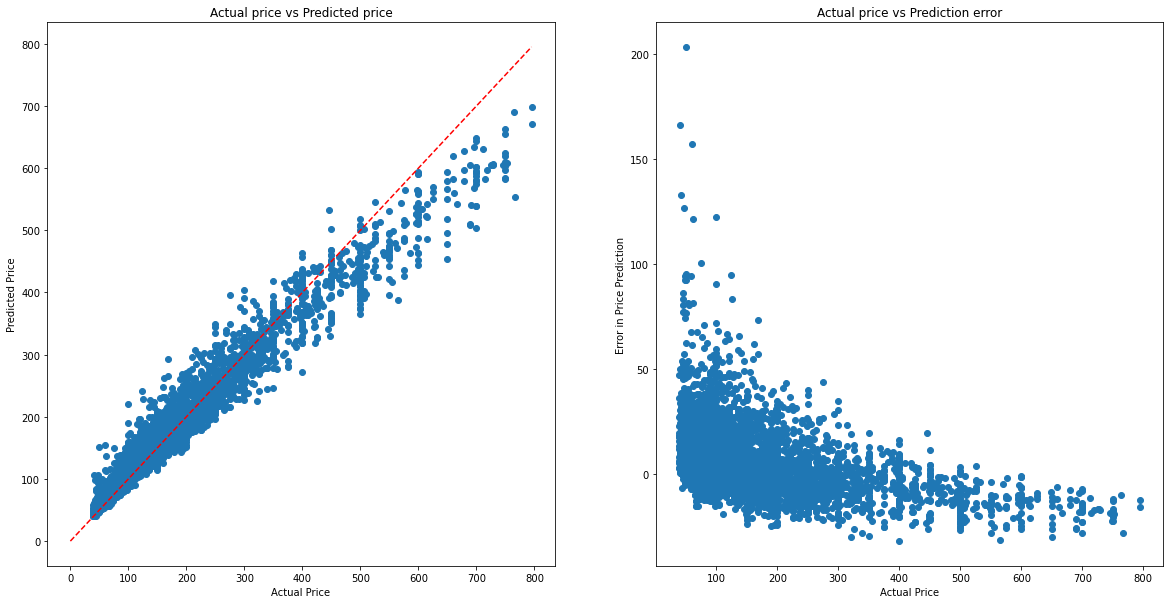

In [13]:
pred_plotter(y_train, y_train_pred)

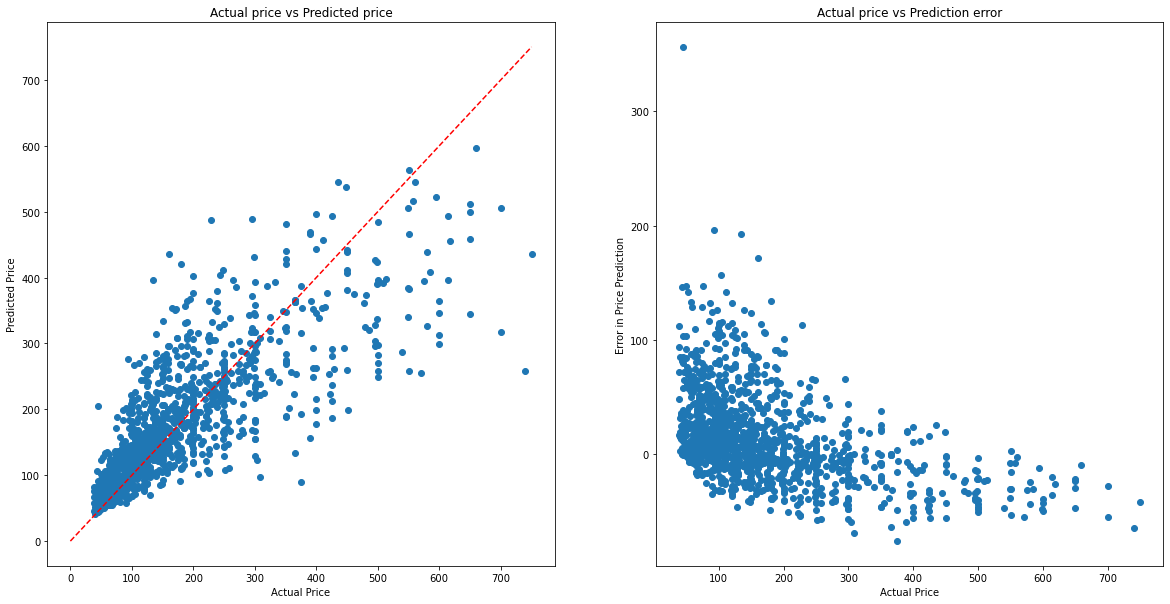

In [14]:
pred_plotter(y_test, y_test_pred)

XGBoost Regressor has the best performance. Hyperparameter tuning will be done.

In [15]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'booster': ['gbtree'],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [1, 3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.3,0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [16]:
#Run only in the first run of the kernel.
#hyperParameterTuning(X_train, y_train)

Here are the paramters that yielded the best model performance: 
    
booster = 'gbtree',
colsample_bytree = 0.7,
learning_rate = 0.1,
max_depth = 5,
min_child_weight = 5,
n_estimators =200,
objective = 'reg:squarederror',
subsample = 0.7

In [17]:
# copying the data frame
df = transformed_df.copy()

# assigning X and y 
X = df.drop('price', axis=1)
y = df.price

# performing train_test_split    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initiating the model
xgb_reg = xgb.XGBRegressor(booster = 'gbtree',colsample_bytree = 0.7,
                           learning_rate = 0.1,max_depth = 5,min_child_weight = 5,
                           n_estimators =200,objective = 'reg:squarederror',subsample = 0.7)

# fitting the model to dataset and making predictions on training and test data
xgb_reg.fit(X_train, y_train)
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

# calculating r^2 for training and test data
Train_r2 = round(r2_score(y_train, y_train_pred),4)
Test_r2 = round(r2_score(y_test, y_test_pred),4)

# printing r^2 for train and test data
print('R2 for training data is: ', Train_r2)
print('R2 for test data is: ', Test_r2)


# doing cross-validation
cv = cross_validate(xgb_reg, X_train, y_train, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

# printing r^2 of the cross validation
print('R2 for cross-validation of training data is: ',cv['train_r2'])    
print('R2 for cross-validation of test data is: ',cv['test_r2'])  

R2 for training data is:  0.8523
R2 for test data is:  0.6689
R2 for cross-validation of training data is:  [0.8633938  0.86837694 0.8677718  0.86894412 0.86948476]
R2 for cross-validation of test data is:  [0.62925208 0.65308309 0.64880057 0.67173499 0.64776198]


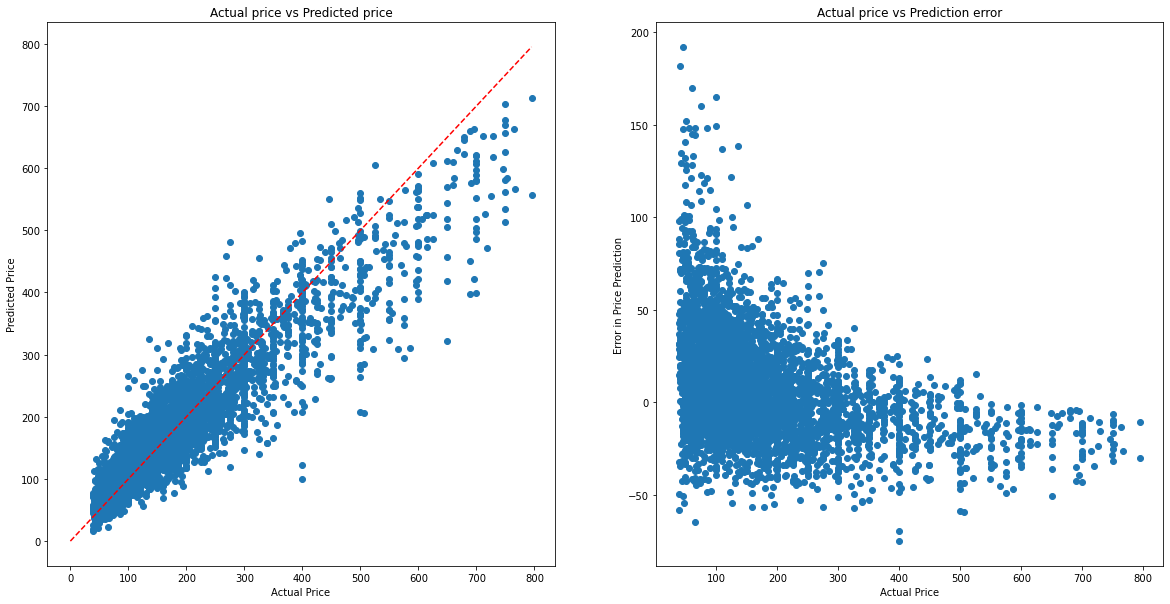

In [18]:
pred_plotter(y_train, y_train_pred)

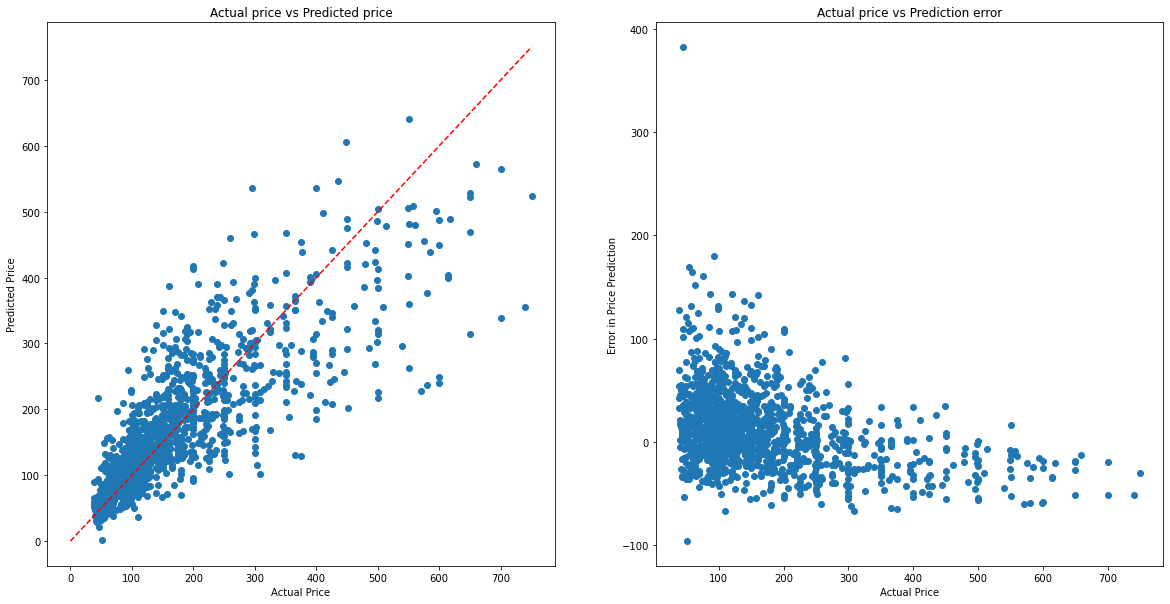

In [19]:
pred_plotter(y_test, y_test_pred)

- There is an interesting behaviour here. Lower prices tend to be predicted higher and higher prices are tend to be predicted lower than their true values. Is it possible to improve model performance by binning listings into different price ranges and optimize the model for each price range. Lets look into error distribution for seeral price ranges

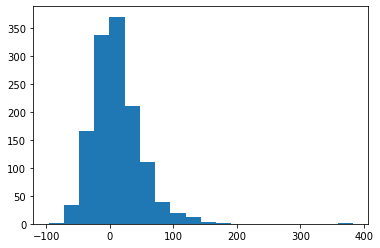

In [20]:
# plotting the error distribution of the test data
x = y_test.values
y = y_test_pred
error = 100 * (y-x)/x
plt.hist(error,bins=20);

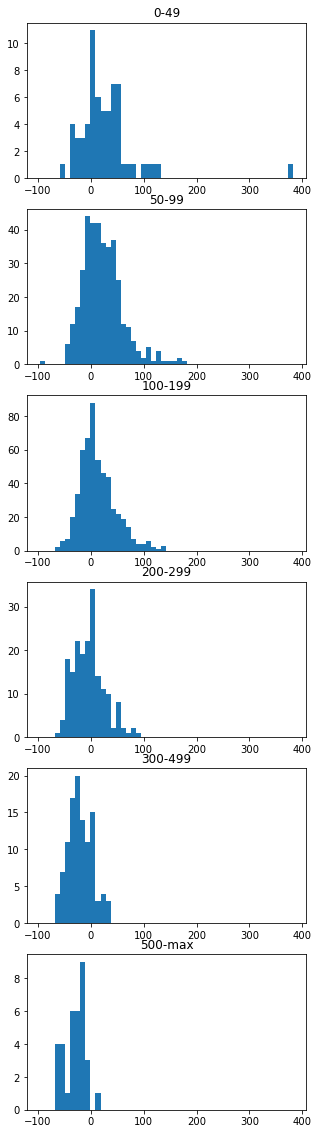

In [21]:
# creating a data frame from y_test and adding error to new data frame
y_test = pd.DataFrame(y_test)
y_test['error'] = error

# creating bins for the since_first_review column
y_test['price_bin'] = pd.cut(y_test.price, 
                               bins = [0,50,100,200,300,500,max(y_test.price)], 
                               labels = ['0-49',
                                         '50-99',
                                        '100-199',
                                        '200-299',
                                        '300-499',
                                        '500-max'], include_lowest=True)

# plotting the error distribution for each bin
bins = ['0-49', '50-99', '100-199', '200-299', '300-499', '500-max']
plt.figure(figsize = (5,20))
for i in range(len(bins)):
    df = y_test[y_test.price_bin == bins[i]]
    plt.subplot(6, 1,i+1)
    plt.hist(df.error, range = (y_test.error.min(),y_test.error.max()),bins=50)
    plt.title(bins[i])

- the error distribution tends to shift from positive to negative when the price is around 200 USD. So, let's divide the data frame into two where price is less or more than 200USD and fit/optimize the model to each data frame and test if the performance improves.

In [22]:
# dividing the data frame based on price
df_price_less200 = transformed_df[transformed_df.price<=200]
df_price_more200 = transformed_df[transformed_df.price>200]

In [23]:
# creating a function to test the 
def model(dataframe):
    
    # copying the data frame
    df = dataframe.copy()

    # assigning X and y 
    X = df.drop('price', axis=1)
    y = df.price

    # performing train_test_split    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # initiating the model
    xgb_reg = xgb.XGBRegressor()

    # fitting the model to dataset and making predictions on training and test data
    xgb_reg.fit(X_train, y_train)
    y_train_pred = xgb_reg.predict(X_train)
    y_test_pred = xgb_reg.predict(X_test)

    # calculating r^2 for training and test data
    Train_r2 = round(r2_score(y_train, y_train_pred),4)
    Test_r2 = round(r2_score(y_test, y_test_pred),4)

    # printing r^2 for train and test data
    print('R2 for training data is: ', Train_r2)
    print('R2 for test data is: ', Test_r2)


    # doing cross-validation
    cv = cross_validate(xgb_reg, X_train, y_train, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

    # printing r^2 of the cross validation
    print('R2 for cross-validation of training data is: ',cv['train_r2'])    
    print('R2 for cross-validation of test data is: ',cv['test_r2'])  

In [24]:
model(df_price_less200)

R2 for training data is:  0.9402
R2 for test data is:  0.6267
R2 for cross-validation of training data is:  [0.9530581  0.94947713 0.95108398 0.95621    0.95402561]
R2 for cross-validation of test data is:  [0.63293576 0.59007683 0.60440463 0.59261971 0.58142652]


In [25]:
model(df_price_more200)

R2 for training data is:  0.9866
R2 for test data is:  0.1838
R2 for cross-validation of training data is:  [0.99043117 0.98968953 0.99115889 0.99056095 0.99093901]
R2 for cross-validation of test data is:  [0.22578983 0.21117223 0.19737155 0.34163584 0.28665401]


R-square obtained for the model trained on data frame that contains prices lower than 200 USD is very similar to the model trained on the whole data frame. Whereas R-square for higher prices are significantly lower. This could be for two reasons:
- The default parameters of the model is not suitable for this data frame so hyperparameter tuning can improve it.
- Size of the data frame for higher prices is small (~25% of the other data frame) so we may not have enough data points.

I will do hyperparameter tuning to test the first idea. 

In [26]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(dataframe):
    # copying the data frame
    df = dataframe.copy()

    # assigning X and y 
    X = df.drop('price', axis=1)
    y = df.price

    # performing train_test_split    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    param_tuning = {
        'booster': ['gbtree'],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [1, 3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.3,0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

#hyperParameterTuning(df_price_more200)

Here are the paramters that yielded the best model performance: 


{'booster': 'gbtree',
 'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [27]:
def model(dataframe):
    
    # copying the data frame
    df = dataframe.copy()

    # assigning X and y 
    X = df.drop('price', axis=1)
    y = df.price

    # performing train_test_split    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # initiating the model
    xgb_reg = xgb.XGBRegressor(booster = 'gbtree', colsample_bytree = 0.7, 
                               learning_rate = 0.01, max_depth = 7, min_child_weight = 3,
                               n_estimators = 500, objective = 'reg:squarederror' ,subsample = 0.5)

    # fitting the model to dataset and making predictions on training and test data
    xgb_reg.fit(X_train, y_train)
    y_train_pred = xgb_reg.predict(X_train)
    y_test_pred = xgb_reg.predict(X_test)

    # calculating r^2 for training and test data
    Train_r2 = round(r2_score(y_train, y_train_pred),4)
    Test_r2 = round(r2_score(y_test, y_test_pred),4)

    # printing r^2 for train and test data
    print('R2 for training data is: ', Train_r2)
    print('R2 for test data is: ', Test_r2)


    # doing cross-validation
    cv = cross_validate(xgb_reg, X_train, y_train, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

    # printing r^2 of the cross validation
    print('R2 for cross-validation of training data is: ',cv['train_r2'])    
    print('R2 for cross-validation of test data is: ',cv['test_r2']) 

In [28]:
model(dataframe = df_price_more200)

R2 for training data is:  0.7826
R2 for test data is:  0.2943
R2 for cross-validation of training data is:  [0.81127875 0.79953696 0.8113112  0.8025616  0.79724597]
R2 for cross-validation of test data is:  [0.30840882 0.36501537 0.33911701 0.38329445 0.41188078]


The model performance has improved compared to the model with the default parameters but R-square is not comparable to the result obtained from the lower prices data frame.

In [29]:
# hyperParameterTuning(df_price_less200)

Here are the paramters that yielded the best model performance: 


{'booster': 'gbtree',
 'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [30]:
def model(dataframe):
    
    # copying the data frame
    df = dataframe.copy()

    # assigning X and y 
    X = df.drop('price', axis=1)
    y = df.price

    # performing train_test_split    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # initiating the model
    xgb_reg = xgb.XGBRegressor(booster = 'gbtree', colsample_bytree = 0.7, 
                               learning_rate = 0.01, max_depth = 10, min_child_weight = 3, 
                               n_estimators = 500, objective = 'reg:squarederror' ,subsample = 0.5)

    # fitting the model to dataset and making predictions on training and test data
    xgb_reg.fit(X_train, y_train)
    y_train_pred = xgb_reg.predict(X_train)
    y_test_pred = xgb_reg.predict(X_test)

    # calculating r^2 for training and test data
    Train_r2 = round(r2_score(y_train, y_train_pred),4)
    Test_r2 = round(r2_score(y_test, y_test_pred),4)

    # printing r^2 for train and test data
    print('R2 for training data is: ', Train_r2)
    print('R2 for test data is: ', Test_r2)


    # doing cross-validation
    cv = cross_validate(xgb_reg, X_train, y_train, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

    # printing r^2 of the cross validation
    print('R2 for cross-validation of training data is: ',cv['train_r2'])    
    print('R2 for cross-validation of test data is: ',cv['test_r2']) 

In [31]:
model(df_price_less200)

R2 for training data is:  0.8791
R2 for test data is:  0.6478
R2 for cross-validation of training data is:  [0.88717411 0.89059545 0.89338747 0.88752638 0.88796874]
R2 for cross-validation of test data is:  [0.66370797 0.63317386 0.6431768  0.64831644 0.63269008]


# Summary:

Here I have tested several models for predicting the price of the airbnb listings. XGBoost model had the best performance. Hyperparameter tuning done for the XGBoost slightly improved the model performance. I have observed that the model over predicts the price for low price range and under predicts the price for the upper price range. Thus I divided the data frame based on price range. Following the hyperparameter tuning, model performance for upper price range was significantly lower than the whole dataset. This could be due to limited amount of data for the upper price range.